# Load Packages

In [384]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import os
import scipy
import re

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import matplotlib.mlab as mlab

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout,LSTM,Embedding
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

import multiprocessing as mp
from joblib import Parallel, delayed
print("Number of processors: ", mp.cpu_count())

#import mutual_info

#mutual_info.test_mutual_information_2d()
import time

import datetime
from datetime import timedelta
from datetime import date
import pytz
import pickle

import bs4
from bs4 import BeautifulSoup
import requests

import nltk

from wordcloud import WordCloud, STOPWORDS


import torch
print(torch.__version__)

import random

Number of processors:  8
1.1.0


In [2]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daliangli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Collection

## Scrape a forum page

In [7]:
def insert_mystr_before_astr(orgstr,mystr,astr="?prune_day"):
    idx = orgstr.index(astr)
    return orgstr[:idx] + mystr + orgstr[idx:]

In [62]:
#We build tools to scrape a page of the cloudynights forum
#The input is a thread like 
#https://www.cloudynights.com/forum/67-refractors/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all
#The output is a list of urls

def soup_a_forum(url,n_pages = 4):
    #n_pages needs to be smaller than the total number of pages in this forum
    soups = []
    page = 1
    title = ""
    while page <= n_pages:
        time.sleep(2)
        if page==1: page_url = url
        else: page_url = insert_mystr_before_astr(orgstr=url,mystr="page-"+str(page),astr="?prune_day")
        fpage1 = requests.get(page_url)
        soup1 = BeautifulSoup(fpage1.content, 'html.parser')
        
        #new_title = soup1.find_all('title')[0].get_text()
        #if title == new_title: break
        #else: title = new_title
        
        soups.append(soup1)
        page += 1
    return soups
    

def from_a_soup_to_url(soup):
    element_list = soup.find_all(id=re.compile("tid-link-......"))
    return [element["href"] for element in element_list] 

def remove_from_list_if_contains_substring(orglist,substring):
    return [ele for ele in orglist if not substring in ele] 

def remove_from_list_if_contains_any_substring(orglist,substrings):
    result = []
    for ele in orglist:
        contains = False
        for substr in substrings:
            if substr in ele: contains = True
        if not contains: result.append(ele)
    return result 

In [17]:
forum_page_urls = ["https://www.cloudynights.com/forum/67-refractors/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/71-eyepieces/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/64-binoculars/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/69-cats-casses/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/66-mounts/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/68-reflectors/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all",
                   "https://www.cloudynights.com/forum/65-binoviewers/?prune_day=100&sort_by=Z-A&sort_key=posts&topicfilter=all"
                  ]

In [18]:
forum_level_soup = [soup_a_forum(forum_url,n_pages=5) for forum_url in forum_page_urls]

In [46]:
url_lists = [np.concatenate([from_a_soup_to_url(page) for page in forum]) for forum in forum_level_soup]

In [202]:
world_filters = ["-you","-we-","money","collection","guidelines","important","mod","how-to","to-improve","info",
                 "improvements","question","auction",
                 "apos-better",
                 "what-is-your","whats-in-your","show-us-your","have-you-found",
                 "post-a-pic","links-of-interest","policy","do-you-own","show-off","no-use","billp","myths-and-misconceptions",
                 "paracorr-settings","eyepiece-buyers-guide","identifying-eyepiece-aberrations","filters-buyers-guide",
                "clarifications","overlooking-the-obvious","most-beautiful","gems-best-of","vintage-and-classic","tinkering",
                 "home-built","collimated","complementary","resolving","birding","not-popular","scams","classical-cassegrain",
                 "focal-reducer","classic-cassegrain","new-scam","best-threads","duplicate","cables","is-soft","corrector",
                 "thermal-issues","collima","coma","make-a-reflector","best-25mm",
                ]

filtered_url_lists = [remove_from_list_if_contains_any_substring(url_list,world_filters) for url_list in url_lists]


In [206]:
#with open('filtered_url_lists', 'wb') as fp:
#    pickle.dump(filtered_url_lists, fp)
    


## Scrape a thread

In [ ]:
#Images not included, emojs not included, author identity not included
#all_soups_s[forum_index][thread_index][page_index] > page html

In [670]:
page = all_soups_s[0][0][1]

pec = page.find(class_="post entry-content ")

lpec = list(pec.children)

print([type(ele) for ele in lpec])
print([ele.name for ele in lpec])

type(lpec[0]) == bs4.element.NavigableString

[<class 'bs4.element.NavigableString'>, <class 'bs4.element.Comment'>, <class 'bs4.element.NavigableString'>, <class 'bs4.element.Tag'>, <class 'bs4.element.NavigableString'>]
[None, None, None, 'br', None]


True

In [672]:
page = all_soups_s[0][0][1]

post = page.find(class_="post_body")

like_text = post.find(class_ = "ipsLikeBar_info").get_text().replace("\n","").replace("\t","")

print(like_text)

count_likes(like_text)

moshen likes this


1

In [648]:
'and' in like_text

True

In [987]:
len(all_soups_s[0][0])

50

In [1203]:
def grab_a_thread(url,n_pages = 30):
    post_entry_text = []
    page = 1
    title = ""
    while page <= n_pages:
        time.sleep(1)
        if page==1: page_url = url
        else: page_url = url + "page-" + str(page)
        fpage1 = requests.get(page_url)
        soup1 = BeautifulSoup(fpage1.content, 'html.parser')
        
        new_title = soup1.find_all('title')[0].get_text()
        if title == new_title: break
        else: title = new_title
        
        post_entry_contents = soup1.find_all(class_ = 'post entry-content ')
        for content in post_entry_contents:
            for parag in content.find_all('p'):
                post_entry_text.append(parag.get_text())
        page += 1
    return post_entry_text

def soup_a_thread(url,n_pages = 30, wait_time = 1):
    soups = []
    page = 1
    title = ""
    while page <= n_pages:
        time.sleep(wait_time)
        if page==1: page_url = url
        else: page_url = url + "page-" + str(page)
        fpage1 = requests.get(page_url)
        soup1 = BeautifulSoup(fpage1.content, 'html.parser')
        
        new_title = soup1.find_all('title')[0].get_text()
        if title == new_title: break
        else: title = new_title
        
        soups.append(soup1)
        page += 1
    return soups

In [1304]:
def text_cleaning(string):
    string += "Edited by"
    string = string[:string.index("Edited by")].replace("\xa0","").replace("\n","").replace("\t","").replace("\r","")
    string = re.sub('\s+', ' ', string).strip()
    return string.replace(" .","").lstrip(".").lstrip(" ").rstrip().replace("...",".").replace("..",".")

def replace_urls(string):
    try:
        url_index = string.index("http")
        string_after = string[url_index:]+" "
        next_space_index = string_after.index(" ")
        string_after = replace_urls(string_after[next_space_index:])
        return (string[:url_index]+' URL '+ string_after).rstrip()
    except: return string

def has_image(post):
    return not post.find(class_ = 'resized_img')==None

def n_images(post):
    imgs = post.find_all(class_ = 'resized_img')
    if imgs == None: return 0
    else: return len(imgs)
    
def count_likes(like_text):
    if like_text == "": return 0
    elif not 'and' in like_text: return 1
    elif not ',' in like_text: return 2
    elif not 'other' in like_text: return 3
    else: 
        index = like_text.index(" other")
        return 3+int(like_text[index-2:index])

def n_likes(post):
    '''Input: beautiful soup object class post_body'''
    '''Output: number of likes to this post'''
    like_info = post.find(class_ = "ipsLikeBar_info")
    if  like_info == None: return 0
    else: 
        like_text = like_info.get_text().replace("\n","").replace("\t","")
        return count_likes(like_text)
    
def extract_title_from_thread_url(a_url):
    return a_url[a_url.index("-")+1:-1].replace("-"," ")

def emojis(post):
    '''Input: beautiful soup object class post_body'''
    '''Output: list of emojis as strings such as [':lol:','lol.gif']'''
    post_entry_content = post.find(class_="post entry-content ")
    content_list = list(post_entry_content.children)
    
    all_emojis = []
    for parts in content_list:
        if parts.name == 'blockquote': continue
        elif parts.name == 'img':
            try: 
                if parts['class'][0]=='bbc_emoticon': all_emojis.append(parts['alt'])
                elif parts['class'][0]=='bbc_img': all_emojis.append(parts['title'])
            except: pass
        else: 
            try: 
                for ele in parts.find_all(class_=re.compile('bbc_img'|'bbc_emot*')):
                    try: all_emojis.append(ele["title"]) 
                    except: 
                        try: all_emojis.append(ele["alt"]) 
                        except: pass
            except: pass
                    
    return all_emojis

def post_to_text(post):
    '''Input: beautiful soup object class post_body'''
    '''Output: cleaned post text'''
    post_entry_content = post.find(class_="post entry-content ")
    content_list = list(post_entry_content.children)
    a_comment = ""
    for parts in content_list:
        if parts.name == 'p': a_comment+=". "+parts.get_text()
        elif type(parts) == bs4.element.NavigableString:a_comment+=". "+parts

    return replace_urls(text_cleaning(a_comment).lower())


def all_info_from_a_souped_thread(a_souped_thread):
    all_info = []
    for page in a_souped_thread:
        posts = page.find_all(class_="post_body")
        for post in posts:
            n_i = n_images(post)
            text_record = text_cleaning(" ".join(emojis(post))+" "+ " ".join(["IMG"]*n_i)+". "+ post_to_text(post))
            all_info.append([text_record,n_likes(post),n_i])
    return all_info

def nltk_sentiment(sentence):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [1204]:
#def post_entry_content_to_text(post_entry_content):
#    content_list = list(post_entry_content.children)
#    a_comment = ""
#    for parts in content_list:
#        if parts.name == 'p': a_comment+=". "+parts.get_text()
#        elif type(parts) == bs4.element.NavigableString:a_comment+=". "+parts
#
#    return text_cleaning(a_comment)


#def has_image(post):
#    return not post.find(class_ = 'resized_img')==None

#def n_images(post):
#    imgs = post.find_all(class_ = 'resized_img')
#    if imgs == None: return 0
#    else: return len(imgs)

#def emojis(post):
#    post_entry_content = post.find(class_="post entry-content ")
#    content_list = list(post_entry_content.children)
    
#    all_emojis = []
#    for parts in content_list:
#        if parts.name == 'blockquote': continue
#        if parts.name == 'img':
#            if parts['class'][0]=='bbc_emoticon':
#                 all_emojis.append(parts['alt'])
#    return all_emojis
    




#def all_comments_from_a_souped_thread(a_souped_thread):
#    all_comments = []
#    for page in a_souped_thread:
#        page_contents = page.find_all(class_="post entry-content ")
#        all_comments += [post_entry_content_to_text(a_content) for a_content in page_contents]
#    return all_comments

#def text_a_class_in_soup(soup,cls = 'post entry-content '):
#    text_res = []
#    contents = soup.find_all(class_ = cls)
#    for content in contents:
#        for parag in content.find_all('p'):
#            text_res.append(parag.get_text())
#    return text_res

In [ ]:
forum_index = 0
thread_index = 0
page_index = 0

all_soups_s[forum_index][thread_index][page_index]

In [1303]:
info_all_threads_all_forums[-1][0]

[['while there is almost no binoviewer i did not try and test, i must share some of my experiences with you i had!. i will show you and will try to explain stuffs which i think to be important, optically and mechanically, so this can guide you in next purchase to choose which one you want.',
  0,
  0],
 ['IMG. william optics, celestron, telescope service, orion, omegon, astro-professional, and simillar. all these binoviewers comes from same factory in china, fromkunming united optics corporation. here is link.  URL  barlow.html. you can also order your own binos with little different outside colours and design which they offer, with your own logo, but you must have company, and you must order minimum amount they require (not small amounts). there is absolutely no difference optically (except difference sometimes in coating colour, all becasue difference in position of coated surface in time when optics are coated in relation vs source which coat). all prisms and correcting glass, are 2

In [1298]:
string = "edit: i've found a recent topic on this subject:. http://www.cloudynig.rence-in-binos/. i hope http"

def replace_urls(string):
    try:
        url_index = string.index("http")
        string_after = string[url_index:]+" "
        next_space_index = string_after.index(" ")
        string_after = replace_urls(string_after[next_space_index:])
        return (string[:url_index]+' URL '+ string_after).rstrip()
    except: return string
    
    
replace_urls(string)

"edit: i've found a recent topic on this subject:.  URL  i hope  URL"

In [220]:
with open ('filtered_url_lists', 'rb') as fp:
     filtered_url_lists = pickle.load(fp)

filtered_url_lists_short = [url_list[:25] for url_list in filtered_url_lists] 

In [223]:
#all_soups_s = []
#for i,filtered_url_list_short in enumerate(filtered_url_lists_short):
#    print("souping url list",i)
#    all_soups_s.append([soup_a_thread(thread,n_pages = 50,wait_time = 0.8) for thread in filtered_url_list_short])

souping url list 0
souping url list 1
souping url list 2
souping url list 3
souping url list 4
souping url list 5
souping url list 6


In [234]:
#This generate a very big file but apparently works
#import sys

#sys.setrecursionlimit(40000)

#with open('all_soups_s', 'wb') as fp:
#     pickle.dump(all_soups_s, fp)

In [676]:
#all_soups_s[1].pop(0)
#filtered_url_lists[1].pop(0)
len(all_soups_s[1])

#with open('filtered_url_lists', 'wb') as fp:
#     pickle.dump(filtered_url_lists, fp)

24

In [434]:
title_lists = [[extract_title_from_thread_url(url) for url in url_list] for url_list in filtered_url_lists]

In [1301]:
#Obtain all info
info_all_threads_all_forums = []
for i,soups in enumerate(all_soups_s):
    print("processing forum:",i)
    info_all_threads_all_forums.append([all_info_from_a_souped_thread(soup) for soup in soups])

processing forum: 0
processing forum: 1
processing forum: 2
processing forum: 3
processing forum: 4
processing forum: 5
processing forum: 6


In [1251]:
string = info_all_threads_all_forums[1][3][0][0]

In [1302]:
info_all_threads_all_forums[1][3]

[[':lol: what are your top 10 eyepieces of all time?  in another thread daniel said this regarding an eyepiece, so i thought it would be an interesting exercise to gather everyone\'s top 10 list then see what the top 10 turns out to be for the community.  rules -- yes.there are rules to follow please so we get some consistency in meaning and intent.  here they go:.  -- must be an eyepiece you have personally either owned or borrowed or used. -- must be an eyepiece that makes the list because you felt is special based on your observing experience (so not because it\'s pretty, collecting, or some other non-observing reason). -- ok if you can\'t think of 10, so give a list of up to 10 that deserve the honor of being singled out for you. -- order in the ranking has no meaning, so don\'t worry about which is #1 vs #10, being anyplace on the list gives it equal honor. -- more than 10 not allowed!! -- but ok to add a list of "honorable mentions" for those of us that just have too hard of a ti

In [866]:
#Obtain all info
#info_all_threads_all_forums = []
#for i,soups in enumerate(all_soups_s):
#    print("processing forum:",i)
#    info_all_threads_all_forums.append([all_info_from_a_souped_thread(soup) for soup in soups])
    
#with open('info_all_threads_all_forums', 'wb') as fp:
#     pickle.dump(info_all_threads_all_forums, fp)

with open ('info_all_threads_all_forums', 'rb') as fp:
     info_all_threads_all_forums = pickle.load(fp)

processing forum: 0
processing forum: 1
processing forum: 2
processing forum: 3
processing forum: 4
processing forum: 5
processing forum: 6


In [865]:
#Obtain the comments
#comments_all_threads_all_forums = []
#for i,soups in enumerate(all_soups_s):
#    print("processing forum:",i)
#    comments_all_threads_all_forums.append([all_comments_from_a_souped_thread(soup) for soup in soups])
    
#with open('comments_all_threads_all_forums', 'wb') as fp:
#     pickle.dump(comments_all_threads_all_forums, fp)

processing forum: 0
processing forum: 1
processing forum: 2
processing forum: 3
processing forum: 4
processing forum: 5
processing forum: 6


## Sraping Dev

In [1279]:
#page_url = "https://www.cloudynights.com/topic/466960-takitis/"
#page_url = "https://www.cloudynights.com/topic/466960-takitis/page-119"
#page_url = "https://www.cloudynights.com/topic/466960-takitis/page-3"
page_url = "https://www.cloudynights.com/topic/511998-review-binoviewers-zeiss-baader-william-optics-siebert-denkmeier/page-3"
fpage1 = requests.get(page_url)
soup1 = BeautifulSoup(fpage1.content, 'html.parser')

In [1267]:
posts = soup1.find_all(class_="post_body")

post_index = 8

post = posts[post_index]

print(n_likes(post))
print(emojis(post))



def post_to_text(post):
    '''Input: beautiful soup object class post_body'''
    '''Output: cleaned post text'''
    post_entry_content = post.find(class_="post entry-content ")
    content_list = list(post_entry_content.children)
    a_comment = ""
    for parts in content_list:
        if parts.name == 'p': a_comment+=". "+parts.get_text()
        elif type(parts) == bs4.element.NavigableString:a_comment+=". "+parts

    return text_cleaning(a_comment)

print(post_to_text(post))



0
[]
i've just discovered this review. once again, it's very interesting denis!. can you elaborate on the coatings of the baader maxbright? you think that it probably comes from the same factoryas other chinese binoviewers, but the coatings are obviously different. this is visible in the link in your signature: the maxbright has blue coatings in your pictures, whereas other chinese binoviewers exhibit deep green coatings.howwould you rate the brightness of the maxbright compared to other binoviewers?. also, i read several years ago that cheap binoviewers have different color rendition on each side. did you notice such effects (i know that the baader mark v is almost perfect in this regard, with very neutral colors on each side.). edit: i've found a recent topic on this subject:. http://www.cloudynig.rence-in-binos/. i hope you will complete this review with the new maxbright, when it will be available.


In [1266]:
post

<div class="post_body">
<p class="posted_info desc lighter ipsType_small">
					Posted <abbr class="published" itemprop="commentTime" title="2015-09-20T22:39:54+00:00">20 September 2015 - 05:39 PM</abbr>
</p>
<div class="post entry-content " itemprop="commentText">
<!--cached-Tue, 17 Sep 2019 06:42:26 +0000--><p><span style="font-size:10pt"><span style="font-family:verdana, sans-serif">I've just discovered this review. Once again, it's very interesting Denis!</span></span></p>
<p> </p>
<p><span style="font-size:10pt"><span style="font-family:verdana, sans-serif">Can you elaborate on the coatings of the Baader Maxbright? You think that it probably comes from the same factory as other Chinese binoviewers, but the coatings are obviously different. This is visible in the link in your signature: the Maxbright has blue coatings in your pictures, whereas other Chinese binoviewers exhibit deep green coatings.<br/>
How would you rate the brightness of the Maxbright compared to other binoviewers

In [1173]:
post = posts[post_index]

post_entry_content=post.find(class_="post entry-content ")

content_list = list(post_entry_content.children)

for parts in content_list:
    try: print(parts.find_all(class_='bbc_img'))
    except: continue

[<img alt="lol.gif" class="bbc_img" src="https://www.cloudynights.com//public/style_emoticons/default/lol.gif" title=":lol:"/>]
[]
[]
[]
[]


In [1174]:
post

<div class="post_body">
<p class="posted_info desc lighter ipsType_small">
					Posted <abbr class="published" itemprop="commentTime" title="2019-09-13T19:56:27+00:00">13 September 2019 - 02:56 PM</abbr>
</p>
<div class="post entry-content " itemprop="commentText">
<!--cached-Sat, 14 Sep 2019 07:31:36 +0000--><blockquote class="ipsBlockquote" data-author="RAKing" data-cid="9621959" data-time="1567717550">
<div>
<p> </p>
<p>But I can imagine that the folks who wrote the instructions are like me and expect everyone to understand how an equatorial mount works.  Imagine my surprise when I tried to explain it to an astronomy friend and he looked at me like I was a babbling idiot. ​<span rel="lightbox"><img alt="lol.gif" class="bbc_img" src="https://www.cloudynights.com//public/style_emoticons/default/lol.gif" title=":lol:"/></span></p>
</div>
</blockquote>
<p>I hope that wasn't me! <img alt=":lol:" class="bbc_emoticon" src="https://www.cloudynights.com//public/style_emoticons/default/lol.gi

In [1092]:
post

<div class="post_body">
<p class="posted_info desc lighter ipsType_small">
					Posted <abbr class="published" itemprop="commentTime" title="2014-06-25T16:55:15+00:00">25 June 2014 - 11:55 AM</abbr>
</p>
<div class="post entry-content " itemprop="commentText">
<!--cached-Sat, 14 Sep 2019 20:18:31 +0000--><blockquote class="ipsBlockquote" data-author="tomcody"><p><img alt=":dalek:" class="bbc_emoticon" src="https://www.cloudynights.com//public/style_emoticons/default/dalek12.gif"/> <img alt=":dalek:" class="bbc_emoticon" src="https://www.cloudynights.com//public/style_emoticons/default/dalek12.gif"/> <img alt=":dalek:" class="bbc_emoticon" src="https://www.cloudynights.com//public/style_emoticons/default/dalek12.gif"/> <img alt=":dalek:" class="bbc_emoticon" src="https://www.cloudynights.com//public/style_emoticons/default/dalek12.gif"/> <img alt=":dalek:" class="bbc_emoticon" src="https://www.cloudynights.com//public/style_emoticons/default/dalek12.gif"/> <img alt=":dalek:" class="bbc_

In [1086]:
blockquote = post.find(class_="ipsBlockquote")

blockquote['class'][0]

'ipsBlockquote'

## Content Recommendation

In [748]:
def ranking(post_info):
    return post_info[1]+len(post_info[0])/1000

def suggest_post(forum,thread,n_posts=5):
    #print(filtered_url_lists[forum][thread])
    thread1 = info_all_threads_all_forums[forum][thread].copy()
    return sorted(thread1,key = ranking,reverse=True)[:n_posts]

In [723]:
suggest_post(forum=0,thread=9,n_posts=5)

https://www.cloudynights.com/topic/576269-at60ed-something-small-from-our-sponsors/


[['I posted this over in the EAA forum but it probably belongs here as well.... My AT60ED was delivered yesterday. I had a chance to use it last night. I purchased this scope to replace my 50mm repurposed guide scope. I can’t use a diagonal with that set up and my neck doesn’t like looking straight up for long periods like it used to.. The AT60ED is well constructed, a touch heavy (actually a tad heavier than my 4” F5 refractor) but very compact. I had to tighten up the focuser just a tad and that seems to keep the focuser from slipping with the 2-inch diagonal. The scope rides well on all my alt/az mounts including: the very light Bogen tripod with the light UA Dwarfstar head and is rock solid on the UA Macrostar. The AT60 can be mounted on the left or right side. The AT60ED and the NVD Micro with accessories all fit in my padded case.. The daytime views are all crisp, color free, and very nice. At 100x (the highest power I used) color was not seen during the day. Spider webs some dis

## Star rating

In [758]:
def star_rating(forum,thread,model='nltk_vader',n_posts=20,verbose=False):    
    best_posts = suggest_post(forum=forum,thread=thread,n_posts=n_posts)
    average_star_rating = 0
    
    if model == 'nltk_vader':
        nltk_sentiment = SentimentIntensityAnalyzer()
        for post in best_posts: 
            post_senti = nltk_sentiment.polarity_scores(post[0])['compound']
            star_rating = (post_senti + 2)*5/3
            average_star_rating += star_rating/n_posts
            post.append(star_rating)
    
    if verbose:
        print(filtered_url_lists[forum][thread])
        for post in best_posts:
            print(post[0][:70],post[1],post[2])
    
    return average_star_rating, best_posts

results = star_rating(forum=6,thread=4,model='nltk_vader',n_posts=20,verbose=True)

https://www.cloudynights.com/topic/657675-new-william-optics-binoviewer-on-the-way/
I'm very much looking forward to joining the ranks of binoviewer users 4 4.9755
I had a most enjoyable evening last night using my C-11 with WO binovi 1 4.9831666666666665
Here's an update on my binoviewer adventure. So far here's what has be 1 4.993833333333333
Before I forget, the William Optics binoviewers are very good opticall 3 4.8615
Hi Bob,. That's great that we have had some clear nights lately. Even  0 4.996666666666667
It remained clear tonight with Milky Way faintly visible from Cygnus d 0 4.9875
Wait until you look at the moon at high magnification. It's not just t 3 4.049166666666667
The new WO Binoviewer showed up today.It is clear tonight to test on a 2 2.3136666666666663
I had a most enjoyable evening last night using my C-11 with WO binovi 0 4.974333333333333
The 217 mm optical path is not the minimum. There is another 35 mm tha 2 4.867166666666667
Well I ran into a problem right from 

## Flair

In [ ]:
#

In [348]:
from flair.data import Sentence
from flair.models import TextClassifier

In [350]:
classifier = TextClassifier.load('en-sentiment')

2019-09-17 16:09:41,551 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/models-v0.4/classy-imdb-en-rnn-cuda%3A0/imdb-v0.4.pt not found in cache, downloading to /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpnmi8c4qq


100%|██████████| 1501979561/1501979561 [02:55<00:00, 8571210.85B/s] 

2019-09-17 16:12:37,280 copying /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpnmi8c4qq to cache at /Users/daliangli/.flair/models/imdb-v0.4.pt


2019-09-17 16:12:42,193 removing temp file /var/folders/wl/71241skj6sz0crzrns9v7k4w0000gn/T/tmpnmi8c4qq
2019-09-17 16:12:42,429 loading file /Users/daliangli/.flair/models/imdb-v0.4.pt


In [369]:
i_forum, i_thread = 1,9

print(filtered_url_lists_short[i_forum][i_thread])

string = comments_all_threads_all_forums[i_forum][i_thread][278]

print(string)

sentence = Sentence(string)
# predict NER tags
classifier.predict(sentence)

# print sentence with predicted labels
print(sentence.labels)

https://www.cloudynights.com/topic/497406-delite-eyepieces/
Tried them out today, and the coatings are the normal Televue level of excellence the eye relief is great, but there was a fair bit of pincushion to my eye (Danny heard me get the Televue guys spun up).... I personally will stick with 24 Panoptics, 17 UWANs, and smaller Naglers for my bino viewing, especially considering the price point. I think they are 100 dollars rich to the price point.. I did ask Al about my personal desire, which is a very high polish Televue quality Ortho, and the response I got was that the Delite would be a better eyepiece. That still doesnt satisfy the desire for an ultra high quality Ortho for me.... Maybe Zeiss, or Nikon, will introduce some..
[POSITIVE (0.6714904308319092)]


In [370]:
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

In [460]:
data

,label,text
192,__label__3,"If you don't mind, let's put this into context..."
337,__label__2,"Euhm sure but 8"" is no 12"" again that's a big ..."
592,__label__1,Here's the long and the short of it (pun inten...
674,__label__5,"Me, too! I was looking at the rille near Arist..."
130,__label__2,Thanks Don. Actually I signed up for CN just t...
...,...,...
117,__label__4,And I got another set (I have 2x23mm and 2x10m...
314,__label__1,"""Young people don't kill civilizations, old pe..."
585,__label__5,"Here you go. Single focus frames, enlarged 2x,..."
651,__label__2,That's great news!. Looking forward to reading...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3a1ca7f0>]],
      dtype=object)

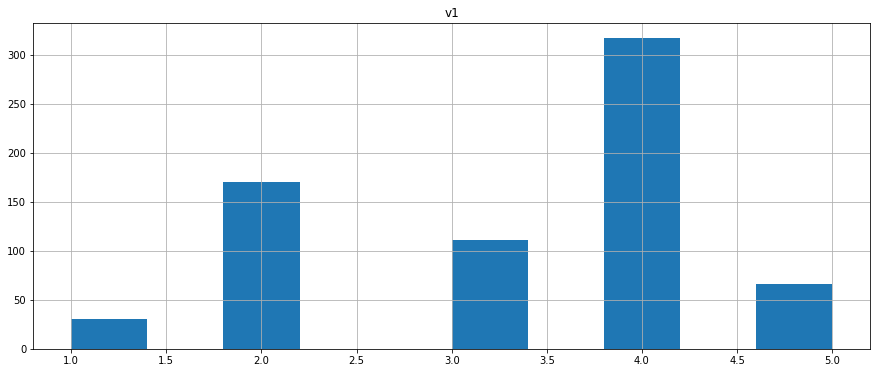

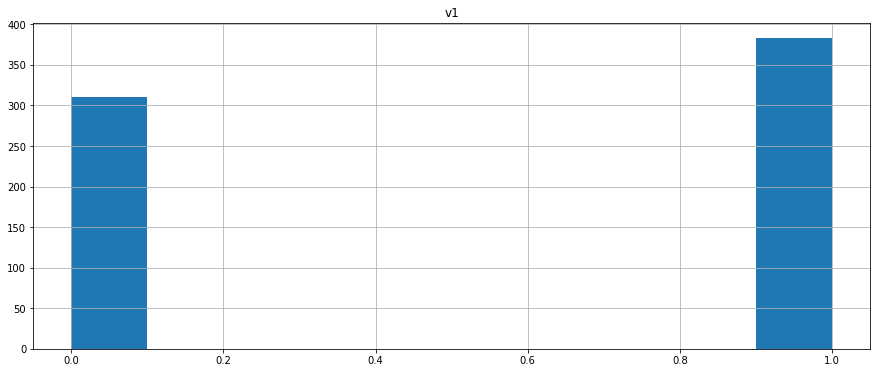

In [727]:
data_exp = pd.read_csv("./data1_hand_labeled_sentiment.csv", encoding='latin-1').sample(frac=1).drop_duplicates()
data_exp.hist()

for i in range(len(data_exp['v1'].values)):
    data_exp['v1'].values[i] = int(data_exp['v1'].values[i]>3)
data_exp.hist()

In [729]:
threshold = 2

data = pd.read_csv("./data1_hand_labeled_sentiment.csv", encoding='latin-1').sample(frac=1).drop_duplicates()
for i in range(len(data['v1'].values)): data['v1'].values[i] = int(data['v1'].values[i]>threshold)
data = data[['v1', 'v2']].rename(columns={"v1":"label", "v2":"text"})
 
data['label'] = '__label__' + data['label'].astype(str)
data.iloc[0:int(len(data)*0.8)].to_csv('train.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.csv', sep='\t', index = False, header = False);

corpus = NLPTaskDataFetcher.load_classification_corpus(Path('./'), 
                                                       test_file='test.csv', 
                                                       dev_file='dev.csv', 
                                                       train_file='train.csv')
word_embeddings = [WordEmbeddings('glove'), 
                   FlairEmbeddings('news-forward-fast'), 
                   FlairEmbeddings('news-backward-fast')]
document_embeddings = DocumentLSTMEmbeddings(word_embeddings, 
                                             hidden_size=512, 
                                             reproject_words=True, 
                                             reproject_words_dimension=256)
classifier_c_senti = TextClassifier(document_embeddings, 
                            label_dictionary=corpus.make_label_dictionary(), 
                            multi_label=False)
trainer = ModelTrainer(classifier_c_senti, corpus)
trainer.train('./', max_epochs=10,learning_rate=0.02,patience = 2)

2019-09-18 23:28:34,524 Reading data from .
2019-09-18 23:28:34,525 Train: train.csv
2019-09-18 23:28:34,526 Dev: dev.csv
2019-09-18 23:28:34,528 Test: test.csv


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated function (or staticmethod) load_classification_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:447: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:454: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:463: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instea

2019-09-18 23:28:36,295 Computing label dictionary. Progress:


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
100%|██████████| 554/554 [00:00<00:00, 241819.59it/s]

2019-09-18 23:28:36,300 [b'1', b'0']
2019-09-18 23:28:36,303 ----------------------------------------------------------------------------------------------------
2019-09-18 23:28:36,305 Model: "TextClassifier(
  (document_embeddings): DocumentLSTMEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=256, bias=True)
    (rnn): GRU(256,

2019-09-18 23:29:27,404 epoch 1 - iter 0/18 - loss 0.71400088 - samples/sec: 0.63
2019-09-18 23:29:48,378 epoch 1 - iter 1/18 - loss 0.68190268 - samples/sec: 1.53
2019-09-18 23:30:10,861 epoch 1 - iter 2/18 - loss 0.67633055 - samples/sec: 1.43
2019-09-18 23:30:24,569 epoch 1 - iter 3/18 - loss 0.67751384 - samples/sec: 2.34
2019-09-18 23:30:36,163 epoch 1 - iter 4/18 - loss 0.64865047 - samples/sec: 2.77
2019-09-18 23:31:26,648 epoch 1 - iter 5/18 - loss 0.63283836 - samples/sec: 0.63
2019-09-18 23:31:39,983 epoch 1 - iter 6/18 - loss 0.62593441 - samples/sec: 2.41
2019-09-18 23:32:15,294 epoch 1 - iter 7/18 - loss 0.61041076 - samples/sec: 0.91
2019-09-18 23:32:34,487 epoch 1 - iter 8/18 - loss 0.61244635 - samples/sec: 1.67
2019-09-18 23:32:45,612 epoch 1 - iter 9/18 - loss 0.62242081 - samples/sec: 2.89
2019-09-18 23:32:51,603 epoch 1 - iter 10/18 - loss 0.61978322 - samples/sec: 5.38
2019-09-18 23:33:01,984 epoch 1 - iter 11/18 - loss 0.62273251 - samples/sec: 3.10
2019-09-18 23:

2019-09-18 23:39:52,405 epoch 5 - iter 6/18 - loss 0.56753873 - samples/sec: 24.40
2019-09-18 23:39:59,674 epoch 5 - iter 7/18 - loss 0.55884052 - samples/sec: 4.44
2019-09-18 23:40:04,950 epoch 5 - iter 8/18 - loss 0.56607845 - samples/sec: 6.13
2019-09-18 23:40:10,312 epoch 5 - iter 9/18 - loss 0.58030796 - samples/sec: 6.04
2019-09-18 23:40:18,389 epoch 5 - iter 10/18 - loss 0.59164259 - samples/sec: 3.99
2019-09-18 23:40:22,239 epoch 5 - iter 11/18 - loss 0.59339044 - samples/sec: 8.42
2019-09-18 23:40:36,777 epoch 5 - iter 12/18 - loss 0.59335987 - samples/sec: 2.21
2019-09-18 23:40:41,816 epoch 5 - iter 13/18 - loss 0.60458683 - samples/sec: 6.42
2019-09-18 23:40:48,223 epoch 5 - iter 14/18 - loss 0.59890784 - samples/sec: 5.04
2019-09-18 23:40:59,450 epoch 5 - iter 15/18 - loss 0.60480230 - samples/sec: 2.86
2019-09-18 23:41:02,256 epoch 5 - iter 16/18 - loss 0.60305980 - samples/sec: 11.62
2019-09-18 23:41:03,027 epoch 5 - iter 17/18 - loss 0.60561051 - samples/sec: 44.56
2019-

2019-09-18 23:46:47,890 epoch 9 - iter 12/18 - loss 0.60365036 - samples/sec: 9.24
2019-09-18 23:46:51,141 epoch 9 - iter 13/18 - loss 0.60164602 - samples/sec: 9.97
2019-09-18 23:46:54,106 epoch 9 - iter 14/18 - loss 0.60416816 - samples/sec: 10.95
2019-09-18 23:47:00,818 epoch 9 - iter 15/18 - loss 0.60166852 - samples/sec: 4.80
2019-09-18 23:47:10,025 epoch 9 - iter 16/18 - loss 0.61018569 - samples/sec: 3.49
2019-09-18 23:47:10,636 epoch 9 - iter 17/18 - loss 0.61202749 - samples/sec: 56.56
2019-09-18 23:47:10,680 ----------------------------------------------------------------------------------------------------
2019-09-18 23:47:10,681 EPOCH 9 done: loss 0.6120 - lr 0.0050
2019-09-18 23:47:11,899 DEV : loss 0.5410113334655762 - score 0.7714
2019-09-18 23:47:11,932 BAD EPOCHS (no improvement): 2
2019-09-18 23:47:15,704 ----------------------------------------------------------------------------------------------------
2019-09-18 23:47:23,525 epoch 10 - iter 0/18 - loss 0.71868998 -

/anaconda3/lib/python3.7/site-packages/torch/serialization.py:574: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


2019-09-18 23:49:07,883 0.6957	0.6957	0.6957
2019-09-18 23:49:07,884 
MICRO_AVG: acc 0.5333 - f1-score 0.6957
MACRO_AVG: acc 0.3478 - f1-score 0.41025
0          tp: 0 - fp: 0 - fn: 21 - tn: 48 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
1          tp: 48 - fp: 21 - fn: 0 - tn: 0 - precision: 0.6957 - recall: 1.0000 - accuracy: 0.6957 - f1-score: 0.8205
2019-09-18 23:49:07,885 ----------------------------------------------------------------------------------------------------


{'test_score': 0.6957,
 'dev_score_history': [0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7714],
 'train_loss_history': [0.6263755096329583,
  0.6223439011308882,
  0.6187207599480947,
  0.6140092064936956,
  0.6056105064021217,
  0.6007027692264981,
  0.610860781537162,
  0.6025561061170366,
  0.6120274894767337,
  0.6067449450492859],
 'dev_loss_history': [tensor(0.5523),
  tensor(0.5580),
  tensor(0.5447),
  tensor(0.5481),
  tensor(0.5464),
  tensor(0.5369),
  tensor(0.5466),
  tensor(0.5404),
  tensor(0.5410),
  tensor(0.5396)]}

In [730]:
threshold = 3

data = pd.read_csv("./data1_hand_labeled_relevance.csv", encoding='latin-1').sample(frac=1).drop_duplicates()
for i in range(len(data['v1'].values)): data['v1'].values[i] = int(data['v1'].values[i]>threshold)
data = data[['v1', 'v2']].rename(columns={"v1":"label", "v2":"text"})
 
data['label'] = '__label__' + data['label'].astype(str)
data.iloc[0:int(len(data)*0.8)].to_csv('train_r.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test_r.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev_r.csv', sep='\t', index = False, header = False);

corpus = NLPTaskDataFetcher.load_classification_corpus(Path('./'), 
                                                       test_file='test_r.csv', 
                                                       dev_file='dev_r.csv', 
                                                       train_file='train_r.csv')
word_embeddings = [WordEmbeddings('glove'), 
                   FlairEmbeddings('news-forward-fast'), 
                   FlairEmbeddings('news-backward-fast')]
document_embeddings = DocumentLSTMEmbeddings(word_embeddings, 
                                             hidden_size=512, 
                                             reproject_words=True, 
                                             reproject_words_dimension=256)
classifier_c_senti = TextClassifier(document_embeddings, 
                            label_dictionary=corpus.make_label_dictionary(), 
                            multi_label=False)
trainer = ModelTrainer(classifier_c_senti, corpus)
trainer.train('./', max_epochs=10,learning_rate=0.02,patience = 2)

2019-09-18 23:49:08,120 Reading data from .
2019-09-18 23:49:08,122 Train: train_r.csv
2019-09-18 23:49:08,123 Dev: dev_r.csv
2019-09-18 23:49:08,124 Test: test_r.csv


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated function (or staticmethod) load_classification_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:447: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:454: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:463: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instea

2019-09-18 23:49:10,752 Computing label dictionary. Progress:


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
100%|██████████| 554/554 [00:00<00:00, 172415.55it/s]

2019-09-18 23:49:10,762 [b'0', b'1']


2019-09-18 23:49:10,974 ----------------------------------------------------------------------------------------------------
2019-09-18 23:49:10,975 Model: "TextClassifier(
  (document_embeddings): DocumentLSTMEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=256, bias=True)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5)
 

/anaconda3/lib/python3.7/site-packages/torch/serialization.py:574: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


2019-09-18 23:50:57,213 0.1739	0.1739	0.1739
2019-09-18 23:50:57,215 
MICRO_AVG: acc 0.0952 - f1-score 0.1739
MACRO_AVG: acc 0.0869 - f1-score 0.14815
0          tp: 0 - fp: 0 - fn: 57 - tn: 12 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
1          tp: 12 - fp: 57 - fn: 0 - tn: 0 - precision: 0.1739 - recall: 1.0000 - accuracy: 0.1739 - f1-score: 0.2963
2019-09-18 23:50:57,216 ----------------------------------------------------------------------------------------------------


{'test_score': 0.1739,
 'dev_score_history': [],
 'train_loss_history': [],
 'dev_loss_history': []}

In [551]:
test_data = data.iloc[int(len(data)*0.9):]
for i,label in enumerate(test_data["label"].values): test_data["label"].values[i] = int(label[-1])

test_data

,label,text
404,0,"Thanks, guys. I've checked Paul's Youtube Cha..."
381,0,"This.. I'm a little bit of an audiophile, and ..."
235,1,Factory solution is to replace the aperture st...
699,0,"Johnny, Jeff is correct! The Barlow ""Slider"" ..."
93,0,Heya Jim. The 6.5mm backfocus spec for the ASI...
...,...,...
304,0,"Thanks Mike! Yo, I'm from Joysey!. Who's Voila..."
542,0,"John said, ""The focus tube should not protrude..."
493,0,OK I guess the club has membership levels- I'm...
593,0,"Due to my Christmas generosity, I will volunte..."


In [733]:
def predict_all(predictor,texts):
    result = []
    for text in texts:
        sentence = Sentence(text)
        predictor.predict(sentence)
        result.append([int(sentence.labels[0].value),sentence.labels[0].score])
        
    return result

c_pred = predict_all(classifier_c_senti,test_data["text"].values)

In [734]:
c_pred

[[0, 0.5345116853713989],
 [0, 0.526680052280426],
 [0, 0.5459133982658386],
 [0, 0.5391666889190674],
 [0, 0.5461491346359253],
 [0, 0.5679156184196472],
 [0, 0.5424973368644714],
 [0, 0.5630432367324829],
 [0, 0.5425291657447815],
 [0, 0.5251601338386536],
 [0, 0.5700692534446716],
 [0, 0.5357963442802429],
 [0, 0.5359060764312744],
 [0, 0.5413738489151001],
 [0, 0.5477930903434753],
 [0, 0.5480183959007263],
 [0, 0.5451238751411438],
 [0, 0.542252779006958],
 [0, 0.5351614356040955],
 [0, 0.5269732475280762],
 [0, 0.5613128542900085],
 [0, 0.5102181434631348],
 [0, 0.5250135064125061],
 [0, 0.5248228311538696],
 [0, 0.5328991413116455],
 [0, 0.5307643413543701],
 [0, 0.518776535987854],
 [0, 0.5409107804298401],
 [0, 0.5305058360099792],
 [0, 0.5254279375076294],
 [0, 0.6011669635772705],
 [0, 0.5555381178855896],
 [0, 0.5547741651535034],
 [0, 0.5690692067146301],
 [0, 0.540546715259552],
 [0, 0.538185179233551],
 [0, 0.5366004109382629],
 [0, 0.5647025108337402],
 [0, 0.5686656236

In [554]:
precision = np.mean(np.array(c_pred).T[0] == test_data["label"].values) 

In [560]:
np.array(c_pred).T[0][list(test_data["label"].values)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
np.array(c_pred).T

In [540]:
sentence.labels[0].value

'0'

In [377]:
i_forum, i_thread = 1,9

print(filtered_url_lists_short[i_forum][i_thread])

string = comments_all_threads_all_forums[i_forum][i_thread][278]

print(string)

sentence = Sentence(string)
# predict NER tags
classifier_c.predict(sentence)

# print sentence with predicted labels
print(sentence.labels)

https://www.cloudynights.com/topic/497406-delite-eyepieces/
Tried them out today, and the coatings are the normal Televue level of excellence the eye relief is great, but there was a fair bit of pincushion to my eye (Danny heard me get the Televue guys spun up).... I personally will stick with 24 Panoptics, 17 UWANs, and smaller Naglers for my bino viewing, especially considering the price point. I think they are 100 dollars rich to the price point.. I did ask Al about my personal desire, which is a very high polish Televue quality Ortho, and the response I got was that the Delite would be a better eyepiece. That still doesnt satisfy the desire for an ultra high quality Ortho for me.... Maybe Zeiss, or Nikon, will introduce some..
[ham (0.9998044371604919)]


## Hand labeling data

In [814]:
#Select subset for hand labeling
#hand_labeled_sample = []

#for j,forum in enumerate(comments_all_threads_all_forums):
    #print("forum", j)
#    for i in range(10):
        #print(len(forum[i]))
#        current_samples = random.sample(forum[i], 10)
#        for sample in current_samples:
#                hand_labeled_sample.append([title_lists[j][i],sample])

#pd.DataFrame(hand_labeled_sample).to_csv('data1.csv', index = True, header = False)

def isNaN(num):
    return num != num

def find_substring_in_list(list_of_strings,sub_string):
    for i,comment in enumerate(list_of_strings):
        if sub_string in comment: return i,comment


#data1_hand = pd.read_csv('data1_hand_labeled.csv',header = None)

#Remove nan, add forum and thread index
#records = []
#index = 0
#for row in data1_hand.iterrows():
#    if not isNaN(row[1][2]): 
#        i_forum = int(index/100)
#        i_thread = int((index%100)/10)
#        i_post,post = find_substring_in_list(comments_all_threads_all_forums[i_forum][i_thread],
#                                             sub_string = row[1][2][:80])
#        records.append([i_forum,i_thread,i_post,row[1][1],post,
#                        info_all_threads_all_forums[i_forum][i_thread][i_post][1],row[1][3],row[1][4]])
#    index += 1
    

#pd_records = pd.DataFrame(records)
#pd_records.columns = ["forum", "thread", "post","thread_title","text","n_likes","sentiment","relevance"]
#pd_records.to_csv('data1_extra.csv', index = False, header = True)

In [936]:
!cd ..   #change to the dir you want 

In [937]:
pwd

'/Users/daliangli/Dropbox/Insight/NLP_project/web_app/flaskexample'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c6a06f748>]],
      dtype=object)

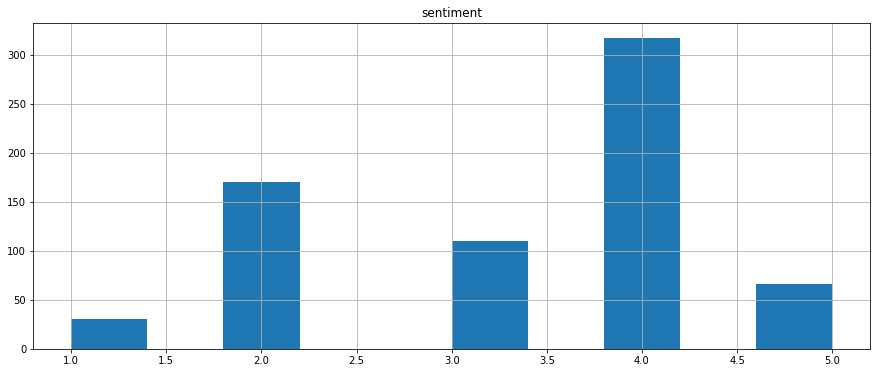

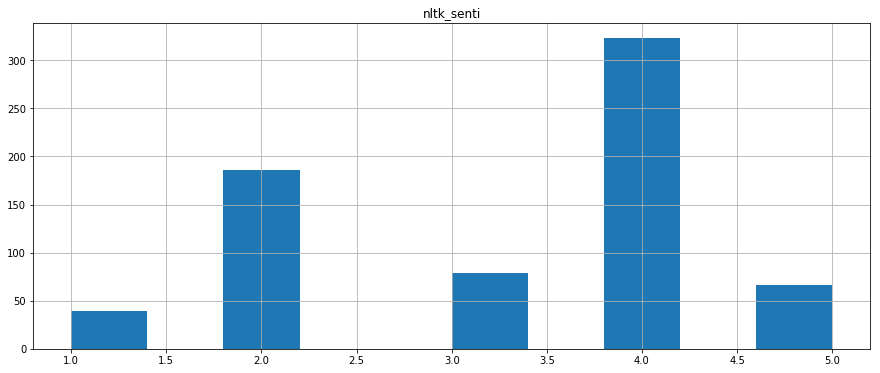

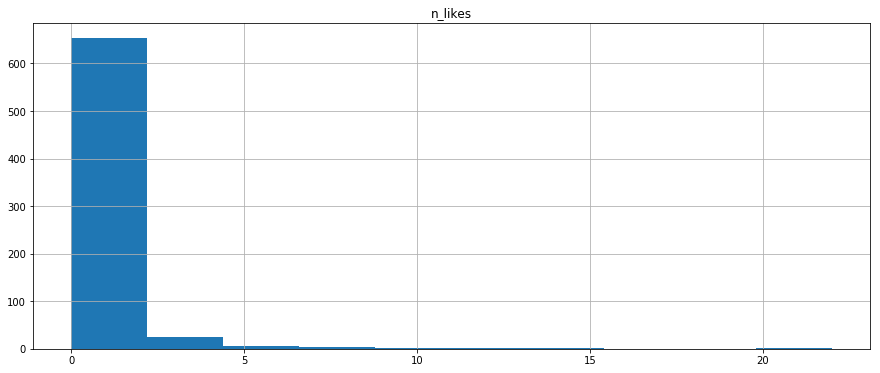

In [952]:
data1_extra = pd.read_csv('data1_extra.csv')

data1_extra.hist(column = 'sentiment')
data1_extra.hist(column = 'nltk_senti')
data1_extra.hist(column = 'n_likes')

In [899]:
data1_extra

,forum,thread,post,thread_title,text,n_likes,sentiment,relevance,nltk_senti
0,0,0,933,takitis,"Sorry, my bad.. However, OPT has the TOA 150B ...",0,3,1,2
1,0,0,474,takitis,You're absolutely correct. I don't believe tha...,0,3,1,2
2,0,0,1233,takitis,Same here Scott. I rarely get the 102 out sinc...,1,5,2,2
3,0,0,280,takitis,Actually they are pretty close as far as I am ...,8,3,3,4
4,0,0,325,takitis,"I got my FC76 used from Japan, and it still ha...",0,4,1,1
...,...,...,...,...,...,...,...,...,...
688,6,9,37,denk binotron first light,"Right on..and Aloha! Nice report, nothing like...",0,5,3,4
689,6,9,76,denk binotron first light,"Jan 15 for me Bruce, with no extra bits, just ...",0,4,2,2
690,6,9,38,denk binotron first light,Mine shipped today!.,0,5,2,2
691,6,9,59,denk binotron first light,The ZAOs were not necessarily bested but they ...,0,4,5,5


In [905]:
data1_senti_bi = data1_extra['sentiment'].values < 4
data1_nltk_senti_bi = data1_extra['nltk_senti'].values < 4
print(1-np.mean(data1_senti_bi))
print(1-np.mean(data1_nltk_senti_bi))
print(np.mean(data1_nltk_senti_bi == data1_senti_bi))

0.5526695526695526
0.5613275613275613
0.6277056277056277


In [849]:
#calculate NLTK sentiment and add that to the datafame
nltk_sentiment = SentimentIntensityAnalyzer()

def nltk_star(string):
    senti = nltk_sentiment.polarity_scores(string)['compound']
    if senti<-0.5: return 1
    elif senti < 0.1: return 2
    elif senti < 0.4: return 3
    elif senti < 0.95: return 4
    else: return 5

data1_extra.iloc[0][4]
data1_extra['nltk_senti'] = data1_extra.apply(lambda row: nltk_star(row['text']), axis=1)

data1_extra.to_csv('data1_extra_processed.csv', index = False, header = True)

In [853]:
hand_senti = data1_extra['sentiment'].values
nltk_sent = data1_extra['nltk_senti'].values

bench_mark = np.ones(len(data1_extra))*4

nltk_senti_absolute_loss = np.mean(np.abs(hand_senti-nltk_sent))
bench_mark_senti_absolute_loss = np.mean(np.abs(hand_senti-bench_mark))

print("nltk has sentiment loss:",nltk_senti_absolute_loss,
      "benchmark has sentiment loss:",bench_mark_senti_absolute_loss)

nltk has sentiment loss: 0.9812409812409812 benchmark has sentiment loss: 0.8744588744588745


## Prepare data for model_zoo

In [945]:
post_index = []
post_text=[]
for index, row in data1_extra.iterrows():
    post_index.append('_'.join([str(row['forum']),str(row['thread']),str(row['post'])]))
    post_text.append(row['text'].replace(',',' '))
    
data1_extra['post_id'] = np.array(post_index)
data1_extra['text'] = np.array(post_text)

data1_extra.to_csv('data1_extra_model.csv', index = False, header = True)

del data1_extra

In [917]:
data1_extra.iloc[10]

forum                                                           0
thread                                                          1
post                                                          296
thread_title    if aperture rules why is it that refractors ar...
text            Collimation is so simple and it takes only a s...
n_likes                                                         0
sentiment                                                       1
relevance                                                       4
nltk_senti                                                      1
Name: 10, dtype: object

In [969]:
info_all_threads_all_forums_flattened = info_all_threads_all_forums
        

In [978]:
n_likes_all_threads_all_forum = [[np.sum([post[1] for post in thread]) 
                                  for thread in forum] for forum in info_all_threads_all_forums]

info_all_threads_w_likes = []
for forum in info_all_threads_all_forums:
    for thread in forum:
        thread sentinp.sum([post[1] for post in thread])
        if 

In [974]:


n_likes_all_threads_all_forum[4]

[17,
 823,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 393,
 0,
 488,
 625,
 165,
 200,
 81,
 139,
 78,
 190,
 142,
 356,
 33,
 0,
 239,
 17]

In [976]:
title_lists[0][:25]

['takitis',
 'if aperture rules why is it that refractors are so popular',
 'the new ap stowaway is coming along',
 'new astro tech at80 at115 at130 edts',
 'the at92',
 '102mm achro for cheap',
 'at102ed on sale has anyone used one',
 'new a p stowaway first lights reviews and shootouts',
 'update on my sw ed150 order',
 'at60ed something small from our sponsors',
 'new takahashi fc 100dl',
 'at 130 and at 115 the second wave',
 'sw150ed and the truth comes out',
 'cheapest ed apo yet barska magnus',
 'discontinued celestron c 4 advanced refractor',
 'is an 80mm good for planetary',
 'starwave 102ed f11 yes ed',
 'explore scientific ar 4 achromatic thoughts',
 'aperture vs focal ratio',
 'skywatcher ed150 doublet coming',
 'skywatcher 150 apo on pre order',
 'ap 175',
 'is astro physics going to release the new stowaway',
 'new 152 mm apm apo in the house',
 'tec 140 the greatest consumer telescope in history']

## CSV files for web_app

In [861]:
info_all_threads_all_forums[forum_index][thread_index][0]

['No, it\'s not an inflammation of your Takahashi!   Instead, I picked up a used FS-102 on AMart and will be doing visual comparisons against my SV-105T as soon as I can.  The Tak should arrive today/tomorrow.  I have a MT Pro and I\'ll see if I can mount both scopes together for doing side-by-sides!     Only issue is that the FS has only 1.25" visual back and I only have a 2" diagonal.   Oh well, I might have to view straight through to compare.   Stay tuned.. pics will be provided when I can..',
 4]

In [ ]:
title

In [867]:
for line in info_all_threads_all_forums[forum_index][thread_index]:
    if len(line)>2: print(line)

In [950]:
forum_index = 1
thread_index = 6

print(title_lists[forum_index][thread_index])

pd_test = None

pd_test = pd.DataFrame(info_all_threads_all_forums[forum_index][thread_index])

pd_test.columns = ["text", "n_likes"]

pd_test.to_csv(title_lists[forum_index][thread_index]+'.csv', index = False, header = True)

baader hyperion 8 24mm zoom


## Precision-recall

NameError: name 'average_precision' is not defined

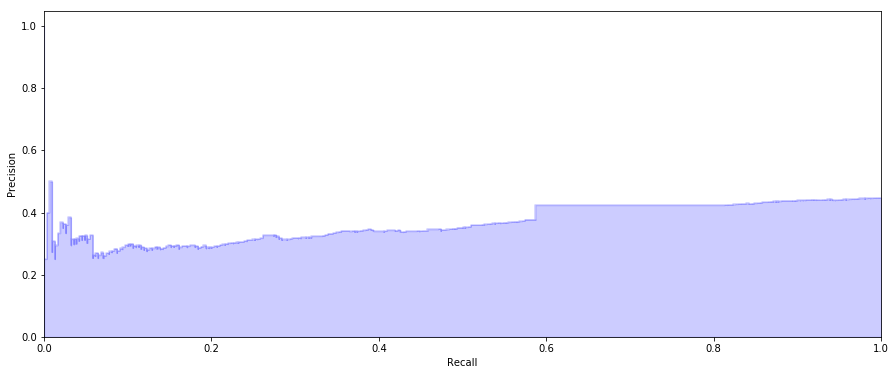

In [915]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

nltk_score = data1_extra.apply(lambda row: (nltk_sentiment.polarity_scores(row['text'])['compound']+1)/2, axis=1).values

precision, recall, thresholds = precision_recall_curve(y_true=data1_senti_bi, probas_pred=nltk_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


## Thread Loader

In [943]:
#pwd

'/Users/daliangli/Dropbox/Insight/NLP_project'

In [894]:
import glob, os
import pandas as pd

def thread_loader(thread_name_substring):
    for file in glob.glob("./static/data/"+thread_name_substring+"*.csv"):
        return pd.read_csv(file)
    
thread_pd = thread_loader("tak")

thread_pd.iloc[0]["text"]

'No, it\'s not an inflammation of your Takahashi!   Instead, I picked up a used FS-102 on AMart and will be doing visual comparisons against my SV-105T as soon as I can.  The Tak should arrive today/tomorrow.  I have a MT Pro and I\'ll see if I can mount both scopes together for doing side-by-sides!     Only issue is that the FS has only 1.25" visual back and I only have a 2" diagonal.   Oh well, I might have to view straight through to compare.   Stay tuned.. pics will be provided when I can..'

## Tests

In [252]:
comments_all_threads = [all_comments_from_a_souped_thread(soup) for soup in soups]
sentiment_all_threads = [np.array([nltk_sentiment(comment)['compound'] for comment in comments]) 
                         for comments in comments_all_threads]

In [278]:
#ids_to_delete = [7,10,13,14,15]

#for i,ids in enumerate(ids_to_delete): del useful_threads[ids-i] 
#for i,ids in enumerate(ids_to_delete): del comments_all_threads[ids-i]  
#for i,ids in enumerate(ids_to_delete): del sentiment_all_threads[ids-i]  
#for i,ids in enumerate(ids_to_delete): del hours[ids-i] 

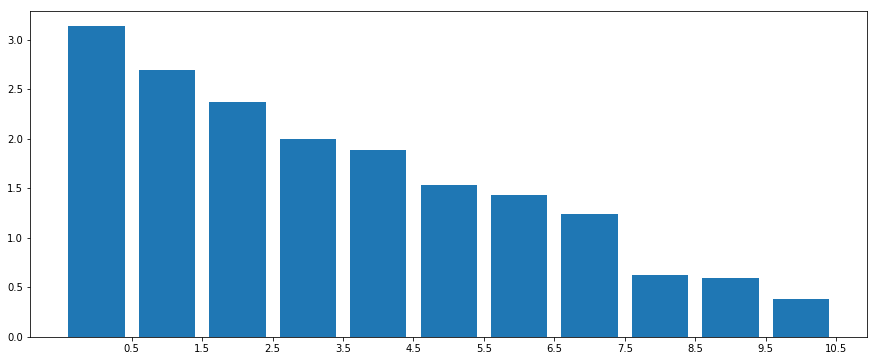

In [289]:
sorted_hours = np.sort(hours)[::-1]

x = np.arange(len(sorted_hours))
plt.bar(x, height= sorted_hours)
plt.xticks(x+.5)
plt.show()

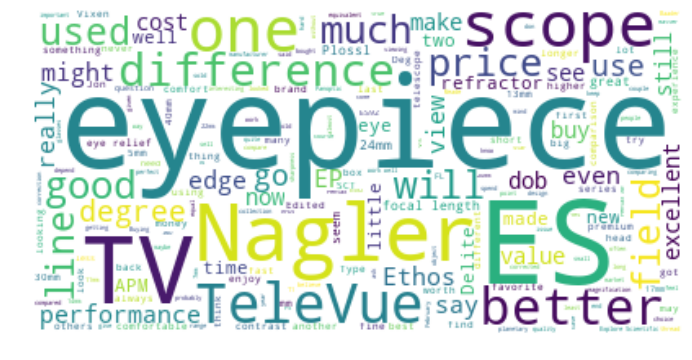

In [285]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(" ".join(comments_all_threads[-5]))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [265]:
def thread_statistics(all_comments_in_a_thread):
    total_string = "".join(all_comments_in_a_thread)
    return total_string.count(" ")
    
hours = [thread_statistics(thread)/250/60 for thread in comments_all_threads]

hours[7]

0.0

In [272]:
soups[0][0].find_all(class_="post entry-content ")

[<div class="post entry-content " itemprop="commentText">
 <!--cached-Thu, 05 Sep 2019 07:50:18 +0000--><p>ANYBODY HAVE ONE OF THESE NIKON NAV 17 HW with EiC-14  102 deg AFOV, OR HAD A CHANCE TO LOOK THROUGH ONE?  WHAT WERE THE VIEWS LIKE?</p>
 <br/>
 </div>, <div class="post entry-content " itemprop="commentText">
 <!--cached-Thu, 05 Sep 2019 07:50:18 +0000--><p>Just got mine about four hour ago.</p>
 <p> </p>
 <p>It's excellent. I'm finding that the 102 degrees is slightly easier to take in than the 100 degrees in the 17 ethos. It also appears to be very sharp indeed, but it is early days for making comparisons.</p>
 <p> </p>
 <p>The views appear equally sharp at 14mm as they are at 17.</p>
 <br/>
 </div>, <div class="post entry-content " itemprop="commentText">
 <!--cached-Thu, 05 Sep 2019 07:50:18 +0000--><p>It is an awesome eyepiece - flat flat flat across the entire field (ap178/tmb175/tec180 refractors). The best view I have had of the double cluster - unforgettable. Go get one.

In [271]:
soups[7][0].find_all(class_="post entry-content ")

[<div class="post entry-content " itemprop="commentText">
 <!--cached-Thu, 05 Sep 2019 08:21:10 +0000-->I got a letter from VernonScope yesterday. It did not say "don't tell anyone", so I'm telling.<br/><br/>Don Yeier is issuing a limited run of 50th Anniversary Brandon sets (limited to 100 sets). Six Brandons (6,8,12,16,24,32mm), gold anodized, in the fancy presentation case (which I can tell you is *very* nice). This is the same set I have, except mine are black, and these don't seem to have eyecups (but I could be wrong about that). <br/><br/>The price is VERY good. If you're contemplating spending Ethos-type money on eyepieces, look into a set of Brandons instead. They won't be available forever, and I'd bet this set won't last long at all.<br/><br/>Brandons are the *only* all-American-made eyepieces (optics, housing, everything), and are among the very finest eyepieces you can get. Eventually Don will retire, and Brandons will either disappear or the brand name will get bought up 

In [267]:
comments_all_threads[7]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [241]:
#a_soup = soup_a_thread("https://www.cloudynights.com/topic/550599-new-es-62-degree-line/")
all_comments_ES62 = all_comments_from_a_souped_thread(a_soup)
sentiments_ES62 = np.array([nltk_sentiment(comment)['compound'] for comment in all_comments_ES62])

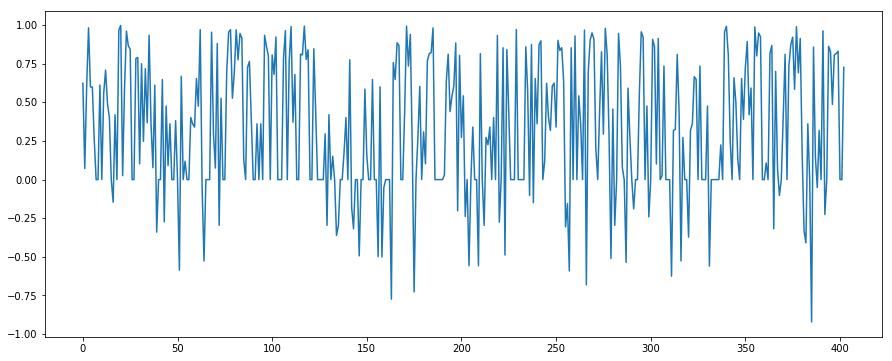

In [290]:
plt.plot(sentiments_ES62)

In [294]:
for i in range(len(all_comments_ES62)):
    if sentiments_ES62[i] <-0.2:
        print(i)
        print(sentiments_ES62[i])
        print(all_comments_ES62[i])

39
-0.34
. Yes, I could pick them up but they were attached to the display bench with a short metal wire so, aside from the weight, it was difficult to judge anything else. The black ring at the bottom of the barrel is possibly part of the anti-theft lock: there weren't any filters attached to it that I remember.. 
Edited by Marcsabb, 22 September 2016 - 11:30 AM.

43
-0.2732
. No information yet.  Still waiting for field stop widths, exact eye reliefs, weights, element and group counts.
51
-0.5859
. Except they say 1.25", which means 62 degrees is wrong...   .  . Obviously, it can't be both 1.25 and 62.  One of the two numbers is a "cut and haste" error.  I was simply pointing out there is another potential explanation.  I've seen plenty of 1.25 40mm plossls labeled as 52s when they can't be...
64
-0.5267
. So are these eyepieces actually going to be available in 2 days?  There is still nothing anywhere about them.  No pictures other than those posted on this thread.  No specs. .  . J

In [297]:
i=391
print(sentiments_ES62[i])
print(all_comments_ES62[i])

0.9631
. https://explorescien...2-32mm-eyepiece. and length 101mm, weight 419.6g, field stop 33.6mm, eye relief 22.2mm. In my f/7 refractor, it was sharp to about the 50° field point and the last 6° on each side with a fair amount of astigmatism.. The 31mm Hyperion deteriorated at about 10-11° from the edge of the field, making the center 50° fairly sharp.. So they are fairly equivalent but for the fact the Hyperion is 10° wider in apparent field (38mm field stop). The ES has noticeably more eye relief..  . Which one is appropriate will depend a lot on the focal length of the scope.. In my 714mm refractor, True fields are 2.7° and 3.0° respectively, which covers the same objects quite well.. But if the f/7 scope were an 8". then true fields would be 1.35° and 1.53° respectively and you might want to go for the wider true field for larger objects.. 
Edited by Starman1, 06 August 2017 - 03:28 PM.



In [292]:
sentiments_ES62.shape

(403,)